In [3]:
import os
import json

import torch
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from model import vit_base_patch16_224_in21k as create_model

class: cooler       prob: 0.000113
class: others       prob: 0.00643
class: shelf        prob: 0.993


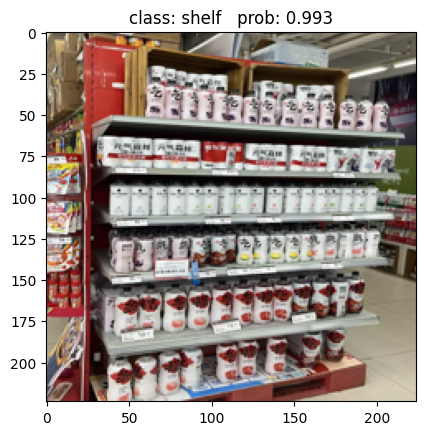

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# load image
img_path = "./images/shelf.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path).resize((224,224))
plt.imshow(img)
plt.savefig('./img.png')
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = create_model(num_classes=3, has_logits=False).to(device)
# load model weights
model_weight_path = "./weights/model-39.pth"
model.load_state_dict(torch.load(model_weight_path, map_location=device))
model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                                predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                                predict[i].numpy()))
plt.show()

In [11]:
patch_embed_layer = model.patch_embed
print(patch_embed_layer)

embed_patch = patch_embed_layer(img.to(device))
print(embed_patch.shape)

print(model.blocks[0])

PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
)
torch.Size([1, 196, 768])
VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop